## Projeto Módulo 2 - Criando Sigma Image e Tratando imagem

Aluna: Yasmin Cavalcante Ferreira Coelho

Esse jupyter notebook irá ilustrar o processo para criar a Sigma Image na banda de 4.5 micrometros para a galáxia NGC3380. Aqui também iremos tratar a imagem dessa galáxia subtraindo o céu presente nela e substituindo os valores "NaNs" (Not-a-Number value) por um valor contante. 


No fim irei salvar as imagens obtidas que serão utilizadas para fazer a decomposição na banda de 4.5 micrometros para essa galáxia.


Mais informações sobre a decomposição e sobre os dados utilizados estão disponíveis no PDF enviado junto com esse notebook.

In [1]:
import numpy as np
import pylab as pl
import astropy.io.fits as fits
import scipy.optimize as opt
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import pandas as pd

from nim_irgalaxies import momento

### Abrindo as imagens

Irei abrir as imagens de duas formas: uma para ter foco em obter informações do header e a outra para fazer contas com os valores dos pixels. Além disso, irei abrir imagens da banda 4.5 e 3.6 micrometros. O motivo disso é apenas fazer uma comparação final do que será obtido.

In [2]:
#Imagens da banda de 4.5um -- todas elas terão um 2 no final para não confundir com as de 3.6um
#Imagens da banda de 3.6um -- todas com um 1 no final

## Primeiro, abrindo imagem para ler o header:
ngc33802 = fits.open('NGC3380.phot.2.fits') #Imagem na banda de 4.5um -- P1 Sheth et al. 2010

#Abrindo de uma maneira diferente para facilitar contas 
#BANDA 4.5um
ngc3380_2 = fits.getdata('NGC3380.phot.2.fits').astype(float)  #Imagem com a galáxia NGC3380 em 4.5um -- P1 Sheth et al. 2010
ngc3380_w2 = fits.getdata('NGC3380.phot.2_wt.fits').astype(float) #weight image para a galáxia NGC3380

#BANDA 3.6um -- apenas para comparação 
ngc3380_1 = fits.getdata('NGC3380.phot.1.fits').astype(float)
ngc3380_1nonan = fits.getdata('NGC3380.phot.1_nonan.fits').astype(float)

ngc3380_1sigma = fits.getdata('NGC3380_sigma2014.fits.gz').astype(float)

## Começando a Sigma Image

Iremos seguir a metodologia utilizada para criar a Sigma Image na banda de 3.6 micrometros. Para isso, usarei o artigo Salo et al. 2015 como manual. Este está disponível em:


https://ui.adsabs.harvard.edu/abs/2015ApJS..219....4S/abstract


Começaremos pela equação 8 do artigo, que calcula o número de elétrons. Primeiro, irei precisar de informações do header:

In [3]:
im4_header = ngc33802[0].header #lendo o header para a imagem em 4.5um

In [4]:
#Vamos olhar os valores que precisamos. Aqui deixarei trechos do artigo entre aspas apenas para sinalizar o que são os valores.

g4 = im4_header.get('GAIN')           # "g is the detector gain factor (GAIN in units of e/DN)"

F_conv4 = im4_header.get('FLUXCONV')  # "in units of MJy sr −1 per DN/s"

F_bg4 = im4_header.get('SKYDRKZB')    # "zodiacal light background"

T_frame4 = im4_header.get('FRAMTIME') # "Note that T frame = 30 s must be used instead 
                                      # of the original integration time/frame given by the header
                                      # keyword FRAMTIME"

N_frames4 = ngc3380_w2 / 10           # "The number of frames combined is coded to the pixel values W of the weight images, 
                                      # N frames = W / 10 ."

F4 = ngc3380_2                        # "F = F gal + F sky."
                                      # "The images provided by P1 are in ﬂux units (MJy sr −1 )"

In [5]:
#Equação 8 -- Número de elétrons -- Equação Salo et al. 2015 (2.2.4)

N_e4 = ((F4 + F_bg4) / (F_conv4)) * (T_frame4 * N_frames4 *g4)

A imagem possui "NaNs", por isso, para melhor visualizar o que está sendo feito, vou cortá-la numa região que englobe a galáxia. Para fins ilustrativos, a imagem da galáxia cortada está abaixo. Essa será a área de pixels que será visualizada.

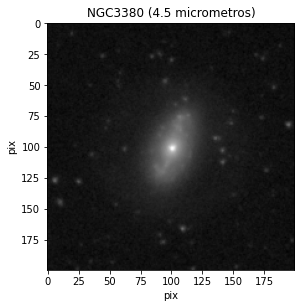

In [6]:
# Chute inicial para o centro da galáxia a partir de uma rápida análise com DS9
x0 = 290  
y0 = 790
image2 = (ngc3380_2)[int(y0)-100:int(y0)+100,int(x0)-100:int(x0)+100] #Cortando a imagem a partir do chute do valor do centro

fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(2,2,1)

## NGC3380 -- 4.5um
ax1.imshow(image2, cmap='gray', norm=LogNorm())
ax1.set_title('NGC3380 (4.5 micrometros)')
ax1.set_ylabel('pix')
ax1.set_xlabel('pix')
plt.show()

In [7]:
#Para fins ilustrativos, valores dos pixels da imagem da galaxia em 4.5um
(ngc3380_2)[int(y0)-100:int(y0)+100,int(x0)-100:int(x0)+100] #ﬂux units (MJy sr −1 )

array([[0.17359017, 0.16934928, 0.17242855, ..., 0.18874331, 0.18429457,
        0.19313648],
       [0.1859723 , 0.18981914, 0.19739242, ..., 0.19832025, 0.19287246,
        0.21090232],
       [0.19645707, 0.19833943, 0.21211372, ..., 0.20199825, 0.18554999,
        0.18157724],
       ...,
       [0.19948086, 0.20361836, 0.20507708, ..., 0.18574513, 0.19150381,
        0.19275393],
       [0.19154802, 0.18937962, 0.18139945, ..., 0.17693944, 0.18250015,
        0.17815728],
       [0.18064737, 0.18364245, 0.18153112, ..., 0.1988799 , 0.20767729,
        0.19643258]])

In [8]:
#Olhando para o valor obtido a partir da equação 8
print(N_e4[int(y0)-100:int(y0)+100,int(x0)-100:int(x0)+100])

[[2106.45282549 1649.39574218 1966.34995905 ... 2048.98200705
  2272.00427666 2167.47514182]
 [2037.49328457 1482.90101998 1952.99303904 ... 2126.8457388
  2383.11988363 2438.20284574]
 [2328.58806262 2142.81669184 1701.1115802  ... 2406.83749432
  1995.02212365 2320.73570586]
 ...
 [2531.61027257 2153.84341439 2362.04287425 ... 1880.56787047
  2358.98781926 2254.9570741 ]
 [2328.2031435  2262.44344461 2239.86775687 ... 2134.31666187
  2197.2829214  2261.60737917]
 [2225.72555822 2423.22133869 1884.22223185 ... 2460.56804159
  2037.50453036 2479.32508003]]


Agora vamos para a equação 9 -- calculando o sigma do Ne.


In [9]:
# "We use RON = 15.0, 14.6, and 21 electrons, for FRAMTIME = 12, 30, and 100 s, respectively."
# Então vamos verificar o valor do FRAMTIME:

print(im4_header.get('FRAMTIME'))

RON4 = 14.6 #pois o valor é 30 

30.0


In [10]:
#Calculando o sigma ^2 de Ne
Sigma2_Ne4 = N_e4 + N_frames4 + RON4**2 # chamando de sigma2 pois é sigma ao quadrado 

In [11]:
#Apenas para visualizar as mudanças nos valores
print(Sigma2_Ne4[int(y0)-100:int(y0)+100,int(x0)-100:int(x0)+100])

[[2327.65772752 1868.93332816 2187.04511225 ... 2269.63870658
  2493.58075157 2388.46996314]
 [2258.16565563 1701.4704419  2173.13123042 ... 2347.58607862
  2604.90043416 2659.76734556]
 [2550.08940478 2363.6135586  1920.11682899 ... 2628.49139767
  2215.54658898 2542.55877348]
 ...
 [2753.76505254 2374.57169824 2583.47063166 ... 2100.66605024
  2580.71320546 2476.27666731]
 [2549.81572376 2483.86656945 2461.3931591  ... 2355.54974002
  2418.62379832 2483.29218309]
 [2447.21587057 2645.3744463  2104.41675715 ... 2682.4845754
  2257.7474779  2701.36697472]]


Por último, vamos para a equação 10. Calculando o sigma do F.

In [12]:
Sigma_est_F = np.sqrt(Sigma2_Ne4) * F_conv4/(T_frame4 * N_frames4 *g4)

In [13]:
#Apenas para visualizar as mudanças nos valores
print(Sigma_est_F[int(y0)-100:int(y0)+100,int(x0)-100:int(x0)+100])

[[0.00791526 0.00894679 0.0081915  ... 0.00838755 0.00783084 0.00823299]
 [0.00834887 0.0100644  0.00881712 ... 0.00843624 0.00781425 0.0080991 ]
 [0.0079904  0.00840233 0.00989435 ... 0.00796659 0.00843579 0.00768229]
 ...
 [0.00770016 0.0084981  0.00811411 ... 0.00871886 0.00782798 0.00804929]
 [0.00788482 0.00796061 0.00782763 ... 0.00793476 0.00793434 0.00771536]
 [0.00783793 0.0075485  0.00860712 ... 0.00780662 0.00885422 0.00772348]]


In [14]:
#Cortando a imagem de 3.6um para comparar os valores das Sigma Images

#Centro da galáxia estimado DS9
x01 = 529
y01 = 286

sigma1_cut = (ngc3380_1sigma)[int(y01)-100:int(y01)+100,int(x01)-100:int(x01)+100] #Sigma image 3.6um cortada

In [15]:
print(sigma1_cut) #Valores da sigma image da banda de 3.6um (Salo et al. 2015) cortada próximo a galáxia 

[[0.01020292 0.01060268 0.0104657  ... 0.01054199 0.0103677  0.01046236]
 [0.01038259 0.01054039 0.01047323 ... 0.01077182 0.01104745 0.01090211]
 [0.01036957 0.01020417 0.0107503  ... 0.01068656 0.01051696 0.01065731]
 ...
 [0.01038442 0.01035839 0.01035527 ... 0.01045638 0.01067502 0.01100874]
 [0.01025857 0.0104587  0.0103704  ... 0.01075241 0.01056731 0.01038975]
 [0.01043126 0.01047229 0.01044948 ... 0.01041292 0.01031143 0.0104295 ]]


Os valores da Sigma Image em 3.6 micrometros são um pouco maiores que os valores obtidos para a Sigma Image em 4.5um. Isso provavelmente não é um problema, pois (como veremos em breve) ao compararmos o fluxo de ambas as bandas, vemos que o fluxo em 3.6um é maior que em 4.5um. 
Considerando isso e a metodologia usada, seria até esperado os valores serem menores.

Por último, vamos salvar a Sigma Image em 4.5um obtida.

In [16]:
fits.writeto('Sigma_est_F.fits', data=Sigma_est_F, overwrite=True) 

## Subtraindo o céu e retirando os NaNs

Primeiro vamos subtrair o céu da imagem. Para isso vamos determinar o centro da galáxia, pois iremos pegar os pixels da área de um anel em torno da galáxia.

In [17]:
#Determinando o centro da galáxia NGC3380 na banda de 4.5um

xc, yc = momento(image2) #importamos a função que nos devolve o fotocentro da imagem utilizando o método do momento

print(xc,yc)

100.85298036066129 101.00838554325378


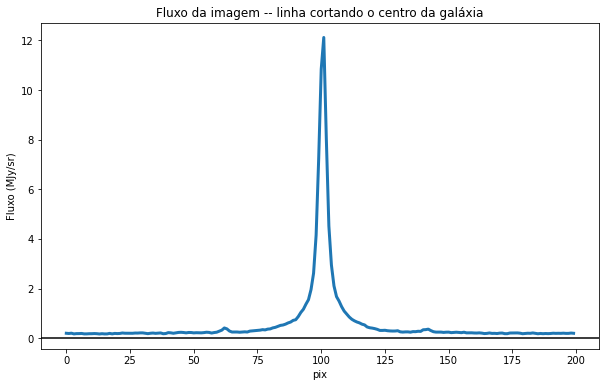

In [18]:
#Se simplesmente plotarmos os valores dos pixels passando pelo centro da galáxia para uma rápida análise, podemos ver que
#o "zero" do gráfico não está no zero. Por isso é importante subtrair o céu.

plt.figure(figsize=[10,6])
plt.plot(image2[int(yc)], lw=3)
plt.axhline(0, color='k')
plt.title('Fluxo da imagem -- linha cortando o centro da galáxia')
plt.ylabel('Fluxo (MJy/sr)')
plt.xlabel('pix')
plt.show()

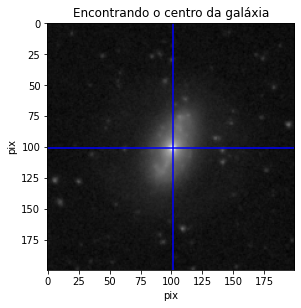

In [19]:
## centro da NGC3380 em 4.5um -- apenas para visualizar 
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(2,2,1)

ax1.imshow(image2, cmap='gray', norm=LogNorm())
ax1.set_title('Encontrando o centro da galáxia')
ax1.axhline(yc, color='blue')
ax1.axvline(xc, color='blue')
ax1.set_ylabel('pix')
ax1.set_xlabel('pix')
plt.show()

In [20]:
#variáveis para ajudar
y = np.arange(image2.shape[0]) #matriz com linhas de 0 a 199
x = np.arange(image2.shape[1]) #matriz com colunas de 0 a 199 

x, y = np.meshgrid(x, y)

#Determinando os raios interno e externo para pegar uma área do céu
outer_ring = 100
inner_ring = 60

mask_sky = ((np.sqrt((x - xc)**2 + (y - yc)**2) < outer_ring) * (np.sqrt((x - xc)**2 + (y - yc)**2) > inner_ring))

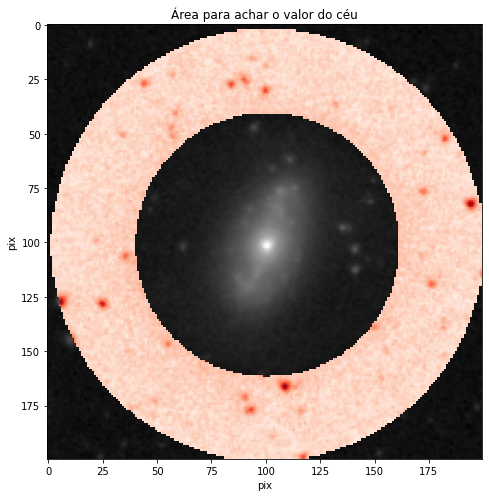

In [21]:
#Vamos visualizar a área que temos para o céu

image_sky = np.copy(image2) # Puramente para ilustração
image_sky[~mask_sky] = np.nan  # Puramente para ilustração

fig = plt.figure(figsize=(8,8))
ax1 = fig.add_subplot(1,1,1)
ax1.set_title('Área para achar o valor do céu')
ax1.imshow(image2, cmap='gray', norm=LogNorm())
ax1.imshow(image_sky, cmap='Reds', alpha=1.0,  norm=LogNorm())
ax1.set_ylabel('pix')
ax1.set_xlabel('pix')
plt.show()

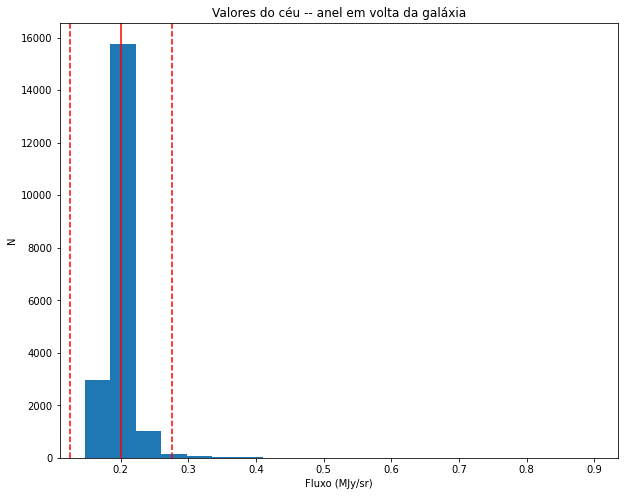

In [22]:
#Plotando um histograma dos valores da área do céu que separamos, conseguimos ver o valor do céu
plt.figure(figsize=[10,8])

plt.hist(image2[mask_sky], 20)
plt.axvline(image2[mask_sky].mean(), color='red') #A média dos valores e o valor do céu que iremos considerar
plt.axvline(image2[mask_sky].mean() + 3*image2[mask_sky].std(), color='red', ls='--')
plt.axvline(image2[mask_sky].mean() - 3*image2[mask_sky].std(), color='red', ls='--')
plt.title('Valores do céu -- anel em volta da galáxia')
plt.ylabel('N')
plt.xlabel('Fluxo (MJy/sr)')

pl.show()

In [23]:
flux_sky = np.sum(image2[mask_sky]) #Fluxo da área do céu -- anel que separamos para achar o céu
print('Fluxo do céu:', flux_sky)

npix_sky = len(image2[mask_sky]) #número de pixels que compoem o anel do céu 
print('Número de pixeis:', npix_sky)
print('\n')
print('Distribuição do Fundo do céu: ' + 
      '{:.4f} +/- {:.4f}'.format(image2[mask_sky].mean(),
                                 image2[mask_sky].std()))

Fluxo do céu: 4023.1594168245792
Número de pixeis: 20056


Distribuição do Fundo do céu: 0.2006 +/- 0.0250


Como temos valores fora de 3 sigmas da distribuição, é bom tirar esses valores, pois queremos o fluxo do céu e ao fazer o anel acabamos adicionando o fluxo de possíveis objetos que podem estar naquela região.
    Por isso, usarei uma função de "sigma clip" para retirar esses valores para obter o valor do céu.

In [24]:
def sigma_clip(value, sigma):
    return value[np.absolute(value - value.mean()) < sigma*value.std(ddof=1)]

In [25]:
sky_flux_cut = sigma_clip(value=image2[mask_sky].ravel(), sigma=3) #Fluxo do céu, retirando valores fora de 3 sigmas

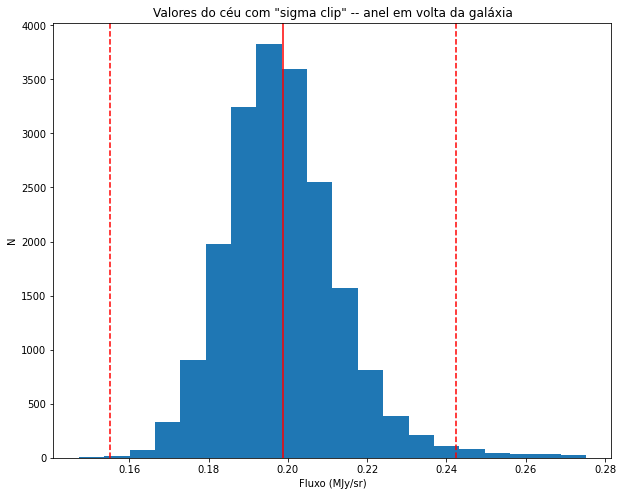

In [26]:
plt.figure(figsize=[10,8])

plt.hist(sky_flux_cut, 20)
plt.axvline(sky_flux_cut.mean(), color='red') #A média dos valores e o valor do céu que iremos considerar
plt.axvline(sky_flux_cut.mean() + 3*sky_flux_cut.std(), color='red', ls='--')
plt.axvline(sky_flux_cut.mean() - 3*sky_flux_cut.std(), color='red', ls='--')
plt.title('Valores do céu com "sigma clip" -- anel em volta da galáxia')
plt.ylabel('N')
plt.xlabel('Fluxo (MJy/sr)')

pl.show()

In [27]:
print('Distribuição do Fundo do céu: ' + '{:.4f} +/- {:.4f}'.format(image2[mask_sky].mean(),  image2[mask_sky].std()))
print('\nDistribuição do Fundo do céu com sigma clip: {:.4f} +/- {:.4f}'.format(sky_flux_cut.mean(), sky_flux_cut.std()))

Distribuição do Fundo do céu: 0.2006 +/- 0.0250

Distribuição do Fundo do céu com sigma clip: 0.1988 +/- 0.0146


E então, vamos subtrair o céu da imagem. Para isso vamos subtrair da nossa imagem o valor médio do céu.

In [30]:
#Subtraindo o céu da imagem 

ngc3380_2nosky = ngc3380_2 - sky_flux_cut.mean()

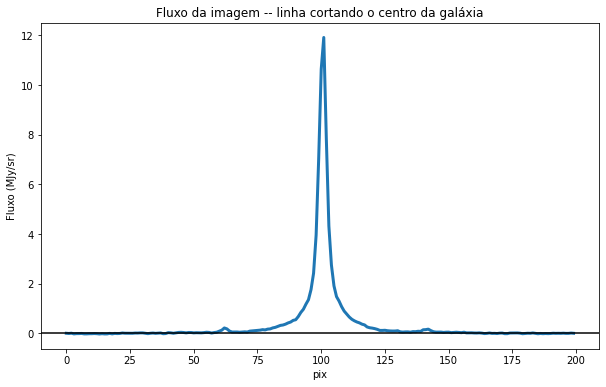

In [31]:
#Agora sem céu

plt.figure(figsize=[10,6])
plt.plot(ngc3380_2nosky[int(y0)-100:int(y0)+100,int(x0)-100:int(x0)+100][int(yc)], lw=3)
plt.axhline(0, color='k')
plt.title('Fluxo da imagem -- linha cortando o centro da galáxia')
plt.ylabel('Fluxo (MJy/sr)')
plt.xlabel('pix')
plt.show()

### Uma rápida comparação entre as bandas!

Para essa parte de comparação, mostrar duas imagens da banda de 3.6um. Uma que estava no mesmo nível (P1, Salo et al. 2010) da imagem que abamos de tratar e a outra que já está pronta para a decomposição.

In [32]:
# Cortando imagens na banda 3.6um -- apenas para uma rápida comparação

#Valor do centro aproximado com DS9
x03 = 529
y03 = 286

image = (ngc3380_1)[int(y03)-100:int(y03)+100,int(x03)-100:int(x03)+100]
image1 = (ngc3380_1nonan)[int(y03)-100:int(y03)+100,int(x03)-100:int(x03)+100]

#centro das imagens
xc3, yc3 = momento(image)
xc31, yc31 = momento(image1)

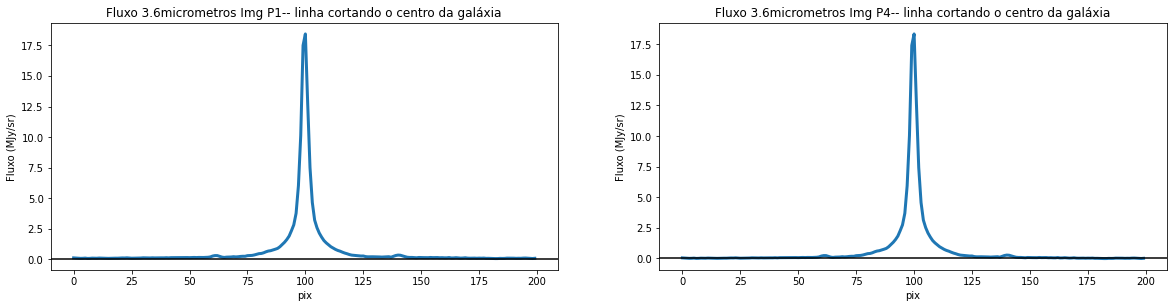

In [33]:
#Fluxo da imagem -- linha cortando o centro da galáxia
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)

ax1.plot(image[int(xc3)], lw=3)
ax1.axhline(0, color='k')
ax2.plot(image1[int(xc31)], lw=3)
ax2.axhline(0, color='k')

ax1.set_title('Fluxo 3.6micrometros Img P1-- linha cortando o centro da galáxia') #Img do pipeline 1
ax2.set_title('Fluxo 3.6micrometros Img P4-- linha cortando o centro da galáxia') #P4 pois essa imagem fica pronta no pipeline 4

ax1.set_ylabel('Fluxo (MJy/sr)')
ax1.set_xlabel('pix')
ax2.set_ylabel('Fluxo (MJy/sr)')
ax2.set_xlabel('pix')

plt.show()

A primeira comparação que gostaria de fazer aqui é que os valores de fluxo na banda de 3.6 micrometros são maiores se comparados aos valores de fluxo na banda de 4.5 micrometros. O plot será feito novamente abaixo apenas para essa rápida comparação de valores.

A segunda comparação entre as bandas que gostaria de apontar é o valor do céu, que na banda de 3.6 micrometros é bem menor (mas não é zero). Farei rapidamente a conta aqui e irei comparar o valor encontrado com esse método com o valor utilizado por Salo et al. 2015.

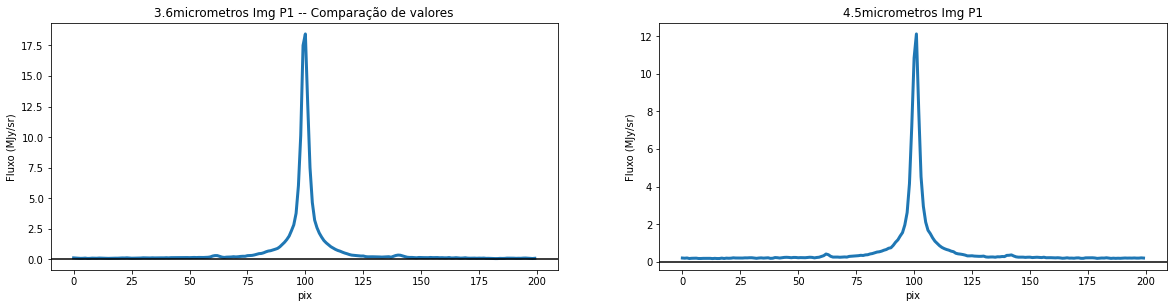

Valor máximo de fluxo em 3.6 micrometros: 18.9443

Valor máximo de fluxo em 4.5 micrometros: 12.1167


In [34]:
#RAPIDA COMPARAÇÃO ENTRE OS VALORES ENTRE AS BANDAS DE 3.6 E 4.5 MICROMETROS
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)

ax1.plot(image[int(xc3)], lw=3)
ax1.axhline(0, color='k')
ax2.plot(image2[int(yc)], lw=3)
ax2.axhline(0, color='k')

ax1.set_title('3.6micrometros Img P1 -- Comparação de valores') #Img do pipeline 1
ax2.set_title('4.5micrometros Img P1') #P4 pois essa imagem fica pronta no pipeline 4

ax1.set_ylabel('Fluxo (MJy/sr)')
ax1.set_xlabel('pix')
ax2.set_ylabel('Fluxo (MJy/sr)')
ax2.set_xlabel('pix')

plt.show()

print('Valor máximo de fluxo em 3.6 micrometros: %.4f' %image.max())
print('\nValor máximo de fluxo em 4.5 micrometros: %.4f' %image2.max())

In [35]:
# RAPIDA COMPARAÇÃO ENTRE OS VALORES DE CÉU ENCONTRAMOS PELO "MÉTODO DO ANEL" UTILIZADO ACIMA PARA A BANDA DE 4.5 MICROMETROS
# E O VALOR DE CÉU UTILIZADO POR SALO ET AL. 2015 
# Para isso irei usar a mesma área utilizada na banda 4.5um
flux_sky = np.sum(image[mask_sky])
print('Flux do céu (banda 3.6 micrometros):', flux_sky)

npix_sky = len(image[mask_sky])

sky_flux_cut1 = sigma_clip(value=image[mask_sky].ravel(), sigma=3) 

print('Número de pixeis:', npix_sky)
print('\n')
print('Distribuição do Fundo do céu (banda 3.6 micrometros):' + 
      '{:.4f} +/- {:.4f}'.format(sky_flux_cut1.mean(),
                                 sky_flux_cut1.std()))

print('\nValor de referência para essa imagem: Sky = 0.0869 -- dsky = 0.0034')

Flux do céu (banda 3.6 micrometros): 2025.3694168515503
Número de pixeis: 20056


Distribuição do Fundo do céu (banda 3.6 micrometros):0.0989 +/- 0.0174

Valor de referência para essa imagem: Sky = 0.0869 -- dsky = 0.0034


O valor de referência da imagem acima foi obtido olhando a tabela 1 (Salo et al. 2015).

tabela 1: https://www.oulu.fi/astronomy/S4G_PIPELINE4/s4g_p4_table1.pdf

### Substituindo valores NaNs por valor contante e salvando a imagem

A escolha do valor constante foi baseada no valor contante da imagem de 3.6um. O que será feito abaixo é simplesmente substituir NaN por "-1.08693" para evitar erro de leitura do GALFIT. Esse valor não irá influenciar na decomposição pois o GALFIT utiliza apenas uma área que determinamos no input da decomposição.

In [36]:
#Antes de da modificação:
print(ngc3380_2nosky)

[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


In [37]:
ngc3380_df = pd.DataFrame(ngc3380_2nosky) 
ngc3380_nonan = ngc3380_df.replace(np.nan,-1.08693) #Substituindo... 
ngc3380_nonan = np.asarray(ngc3380_nonan, dtype=np.float32)

print(ngc3380_nonan)

[[-1.08693 -1.08693 -1.08693 ... -1.08693 -1.08693 -1.08693]
 [-1.08693 -1.08693 -1.08693 ... -1.08693 -1.08693 -1.08693]
 [-1.08693 -1.08693 -1.08693 ... -1.08693 -1.08693 -1.08693]
 ...
 [-1.08693 -1.08693 -1.08693 ... -1.08693 -1.08693 -1.08693]
 [-1.08693 -1.08693 -1.08693 ... -1.08693 -1.08693 -1.08693]
 [-1.08693 -1.08693 -1.08693 ... -1.08693 -1.08693 -1.08693]]


Por último, vamos salvar nossa imagem para utiliza-la mais tarde para a decomposição em 4.5 micrometros

In [38]:
fits.writeto('NGC3380.phot.2_noskynonan', data=ngc3380_nonan, overwrite=True) 